In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Load the CSV file into a DataFrame
y = pd.read_csv('../../../4 - Data/04_WorkingDatasets/Top50CombLagged/TargetOutliersTreated.csv')

# Display the DataFrame
y.head()

np.random.seed(11)
random.seed(11)



In [2]:
# Spliting the data
def train_test_val_split(data, train_ratio=0.7, test_ratio=0.2):
    """
    Splits the dataset into Train, Test, and Validation sets.
    Parameters:
        data: DataFrame - The full dataset to split.
        train_ratio: float - Proportion of data to use for training.
        test_ratio: float - Proportion of data to use for testing.
    Returns:
        train_data, test_data, val_data - DataFrames for train, test, and validation splits.
    """
    train_size = int(len(data) * train_ratio)
    test_size = int(len(data) * test_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:train_size + test_size]
    val_data = data[train_size + test_size:]
    return train_data, test_data, val_data

# Call the function to split the data
train_data, test_data, val_data = train_test_val_split(y)


AR model

In [3]:
from joblib import Parallel, delayed


# Initialize Results DataFrames
results_test = pd.DataFrame(index=["Test MSE", "Test MAE"], columns=np.arange(1, 25))
results_validate = pd.DataFrame(index=["Validation MSE", "Validation MAE"], columns=np.arange(1, 25))

# AR Model Fitting and Error Calculation
def fit_ar_model(p, train_data, test_data, val_data):
    try:
        # Fit AR model
        model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(p, 0, 0))
        res = model.fit()

        # Forecast for test set
        test_forecast = res.forecast(steps=len(test_data))
        test_mse = ((test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values) ** 2).mean()
        test_mae = np.abs(test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values).mean()

        # Forecast for validation set
        val_forecast = res.forecast(steps=len(val_data))
        val_mse = ((val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values) ** 2).mean()
        val_mae = np.abs(val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values).mean()

        return test_mse, test_mae, val_mse, val_mae
    except Exception as e:
        print(f"Error for p={p}: {e}")
        return np.nan, np.nan, np.nan, np.nan

# Run in parallel for AR lags (p) from 1 to 24
results = Parallel(n_jobs=-1)(delayed(fit_ar_model)(p, train_data, test_data, val_data) for p in range(1, 25))

# Store results in DataFrames
for idx, (test_mse, test_mae, val_mse, val_mae) in enumerate(results):
    p_value = idx + 1
    results_test.loc["Test MSE", p_value] = test_mse
    results_test.loc["Test MAE", p_value] = test_mae
    results_validate.loc["Validation MSE", p_value] = val_mse
    results_validate.loc["Validation MAE", p_value] = val_mae

# Combine results into a single DataFrame for display
final_results = pd.concat([results_test, results_validate], axis=0)
print(final_results.to_string(index=True))


                       1          2          3          4          5          6          7          8          9          10         11         12         13         14         15         16         17         18         19         20         21         22         23         24
Test MSE        61.930831  61.947062  61.930869  61.922946  61.902523  61.892474  61.866535  61.841601  61.806615   61.75651  61.689672  61.577971  61.455022  61.360658  61.256401  61.106079  60.981563  60.898779  60.792723  60.706564  60.665212  60.661094  60.689441  60.705818
Test MAE          6.07293    6.07417   6.073069   6.072476   6.071044   6.070367   6.068653    6.06709   6.065009   6.061971   6.057913    6.05061   6.042295   6.035739   6.028223   6.016793   6.006584   5.998967   5.988018   5.976469   5.966079   5.958028   5.948168   5.944483
Validation MSE  35.774269  35.807177  35.776423  35.761724   35.72696  35.710942  35.671789  35.637521  35.594155  35.535317  35.462714  35.335865  35.194413  35.0

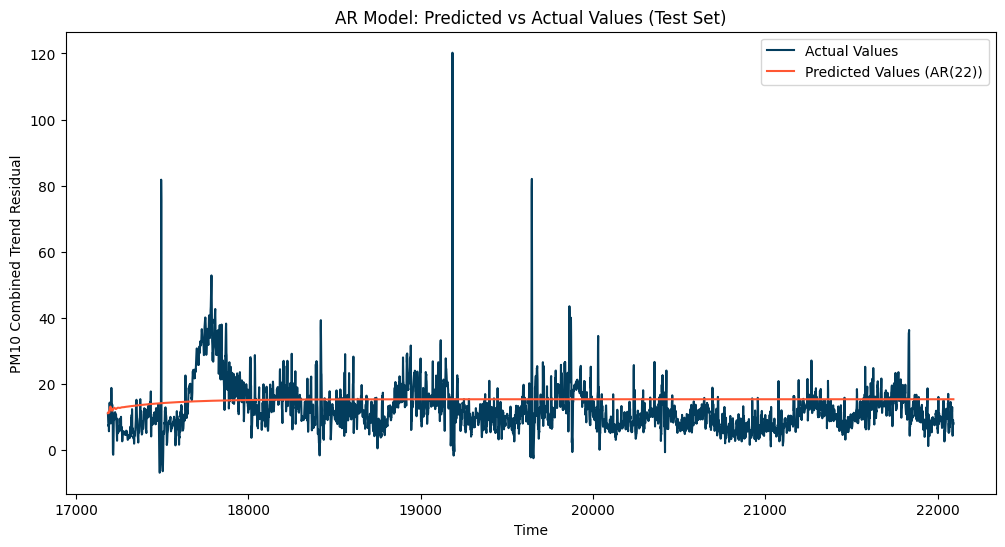

In [4]:
import matplotlib.pyplot as plt

# Assuming `best_p` is the order of AR model with the best performance, determined from `results_test`
best_p = results_test.loc["Test MSE"].astype(float).idxmin()  # Find p with the lowest Test MSE

# Fit the AR model with the best p-value
best_model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(int(best_p), 0, 0)).fit()

# Forecast for the test set
test_forecast = best_model.forecast(steps=len(test_data))

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["PM10_Combined_Trend_Residual"], label="Actual Values", color="#033D5D")
plt.plot(test_data.index, test_forecast.values, label=f"Predicted Values (AR({best_p}))", color="#FF5733")
plt.xlabel("Time")
plt.ylabel("PM10 Combined Trend Residual")
plt.title("AR Model: Predicted vs Actual Values (Test Set)")
plt.legend()

# Save the plot
plt.savefig("AR_Predicted_vs_Actual.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


MA Model 


In [5]:
# Initialize Results DataFrames
results_test = pd.DataFrame(index=["Test MSE", "Test MAE"], columns=np.arange(1, 25))
results_validate = pd.DataFrame(index=["Validation MSE", "Validation MAE"], columns=np.arange(1, 25))

# MA Model Fitting and Error Calculation
def fit_ma_model(q, train_data, test_data, val_data):
    try:
        # Fit MA model
        model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(0, 0, q))
        res = model.fit()

        # Forecast for test set
        test_forecast = res.forecast(steps=len(test_data))
        test_mse = ((test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values) ** 2).mean()
        test_mae = np.abs(test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values).mean()

        # Forecast for validation set
        val_forecast = res.forecast(steps=len(val_data))
        val_mse = ((val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values) ** 2).mean()
        val_mae = np.abs(val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values).mean()

        return test_mse, test_mae, val_mse, val_mae
    except Exception as e:
        print(f"Error for q={q}: {e}")
        return np.nan, np.nan, np.nan, np.nan

# Run in parallel for MA lags (q) from 1 to 24
results = Parallel(n_jobs=-1)(delayed(fit_ma_model)(q, train_data, test_data, val_data) for q in range(1, 25))

# Store results in DataFrames
for idx, (test_mse, test_mae, val_mse, val_mae) in enumerate(results):
    q_value = idx + 1
    results_test.loc["Test MSE", q_value] = test_mse
    results_test.loc["Test MAE", q_value] = test_mae
    results_validate.loc["Validation MSE", q_value] = val_mse
    results_validate.loc["Validation MAE", q_value] = val_mae

# Combine results into a single DataFrame for display
final_results = pd.concat([results_test, results_validate], axis=0)
print(final_results.to_string(index=True))

                       1          2          3          4          5          6          7          8          9          10         11         12         13         14         15         16         17         18         19         20         21         22         23         24
Test MSE        62.040636  62.037588  62.032478  62.027896  62.022965  62.017749  62.012089  62.010461   62.01218  62.009351  62.003946  62.000367  61.996788  61.991409  61.988509  61.991837  61.993119  61.993922  61.997359  62.000175  62.002868  62.003292  62.003328  62.001253
Test MAE         6.083365   6.082871   6.082268   6.081859   6.081445   6.080972   6.080593   6.080632    6.08077   6.080389   6.079798   6.079431    6.07908   6.078534   6.078172   6.078517   6.078421   6.078296   6.078567   6.078816   6.079145   6.079271   6.079289   6.079217
Validation MSE  36.030657  36.023074  36.011583  36.001435  35.991232  35.980948  35.970705  35.968954  35.971517  35.964011  35.952047  35.944068  35.936009  35.9

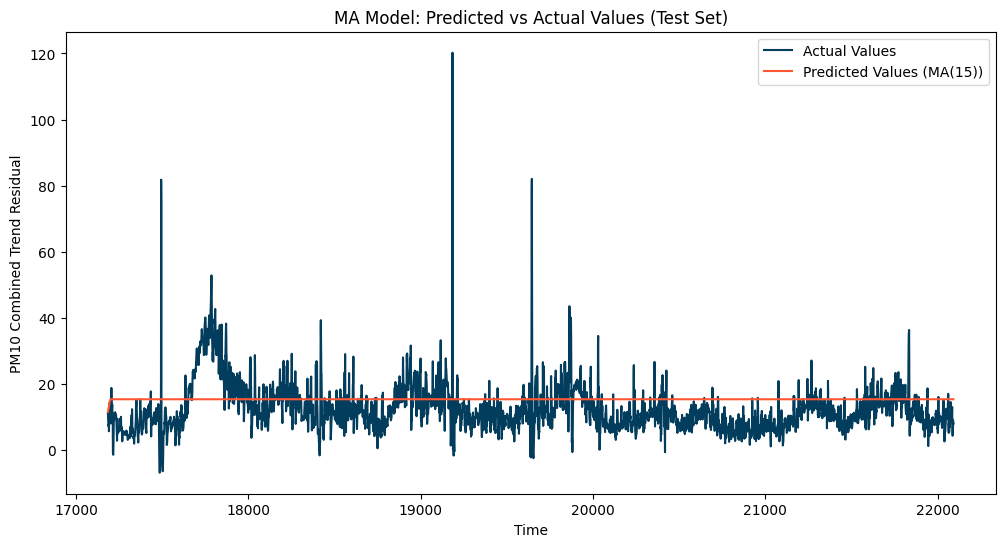

In [6]:
import matplotlib.pyplot as plt

# Assuming `best_q` is the lag order of the MA model with the best performance, determined from `results_test`
best_q = results_test.loc["Test MSE"].astype(float).idxmin()  # Find q with the lowest Test MSE

# Fit the MA model with the best q-value
best_ma_model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(0, 0, int(best_q))).fit()

# Forecast for the test set
test_forecast_ma = best_ma_model.forecast(steps=len(test_data))

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["PM10_Combined_Trend_Residual"], label="Actual Values", color="#033D5D")
plt.plot(test_data.index, test_forecast_ma.values, label=f"Predicted Values (MA({best_q}))", color="#FF5733")
plt.xlabel("Time")
plt.ylabel("PM10 Combined Trend Residual")
plt.title("MA Model: Predicted vs Actual Values (Test Set)")
plt.legend()

# Save the plot
plt.savefig("MA_Predicted_vs_Actual.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


ARMA model für mein laptop aktuell nur mit p und q bis 5

In [7]:
# Initialize Results DataFrames
#results_test = pd.DataFrame(index=["Test MSE", "Test MAE"], columns=[(p, q) for p in range(1, 6) for q in range(1, 6)])
#results_validate = pd.DataFrame(index=["Validation MSE", "Validation MAE"], columns=[(p, q) for p in range(1, 6) for q in range(1, 6)])

results_test = pd.DataFrame(index=["Test MSE", "Test MAE"], columns=pd.MultiIndex.from_product([range(1, 6), range(1, 6)], names=["p", "q"]))
results_validate = pd.DataFrame(index=["Validation MSE", "Validation MAE"], columns=pd.MultiIndex.from_product([range(1, 6), range(1, 6)], names=["p", "q"]))


# ARMA Model Fitting and Error Calculation
def fit_arma_model(p, q, train_data, test_data, val_data):
    try:
        # Fit ARMA model
        model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(p, 0, q))
        res = model.fit()

        # Forecast for test set
        test_forecast = res.forecast(steps=len(test_data))
        test_mse = ((test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values) ** 2).mean()
        test_mae = np.abs(test_data["PM10_Combined_Trend_Residual"].values - test_forecast.values).mean()

        # Forecast for validation set
        val_forecast = res.forecast(steps=len(val_data))
        val_mse = ((val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values) ** 2).mean()
        val_mae = np.abs(val_data["PM10_Combined_Trend_Residual"].values - val_forecast.values).mean()

        return test_mse, test_mae, val_mse, val_mae
    except Exception as e:
        print(f"Error for (p, q)=({p}, {q}): {e}")
        return np.nan, np.nan, np.nan, np.nan

# Run in parallel for ARMA combinations (p, q) from (1, 1) to (5, 5)
results = Parallel(n_jobs=-1)(
    delayed(fit_arma_model)(p, q, train_data, test_data, val_data) 
    for p in range(1, 6) for q in range(1, 6)
)

# Store results in DataFrames
for idx, (test_mse, test_mae, val_mse, val_mae) in enumerate(results):
    p, q = results_test.columns[idx]
    results_test.loc["Test MSE", (p, q)] = test_mse
    results_test.loc["Test MAE", (p, q)] = test_mae
    results_validate.loc["Validation MSE", (p, q)] = val_mse
    results_validate.loc["Validation MAE", (p, q)] = val_mae

# Combine results into a single DataFrame for display
final_results = pd.concat([results_test, results_validate], axis=0)
print(final_results.to_string(index=True))


p                       1                                                      2                                                      3                                                      4                                                      5                                            
q                       1          2          3          4          5          1          2          3          4          5          1          2          3          4          5          1          2          3          4          5          1          2          3          4          5
Test MSE        61.947282  61.926323  61.900502  60.734364  60.709878     61.936  60.295419  60.525735  60.453936  59.138063  59.981875  59.855782    60.7378  55.590106  60.764156  57.233036  54.631598  60.448655  60.734262  60.787439  59.972893  53.551927  60.698533  60.707324  60.780982
Test MAE         6.074183   6.072719    6.07085   5.928816   5.920261   6.073303   5.881446   5.962621   5.894402   5.816255   5.8

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


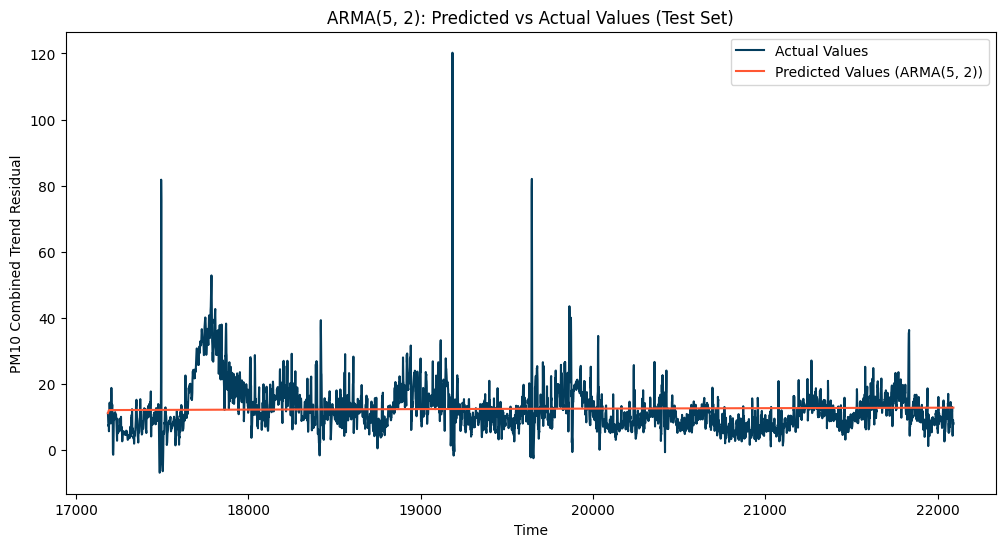

In [8]:
import matplotlib.pyplot as plt

# Find the best (p, q) combination with the lowest Test MSE
best_pq = results_test.loc["Test MSE"].astype(float).idxmin()  # (p, q) with minimum MSE
best_p, best_q = best_pq

# Fit the ARMA model with the best (p, q) combination
best_arma_model = sm.tsa.ARIMA(train_data["PM10_Combined_Trend_Residual"], order=(best_p, 0, best_q)).fit()

# Forecast for the test set
test_forecast_arma = best_arma_model.forecast(steps=len(test_data))

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["PM10_Combined_Trend_Residual"], label="Actual Values", color="#033D5D")
plt.plot(test_data.index, test_forecast_arma.values, label=f"Predicted Values (ARMA({best_p}, {best_q}))", color="#FF5733")
plt.xlabel("Time")
plt.ylabel("PM10 Combined Trend Residual")
plt.title(f"ARMA({best_p}, {best_q}): Predicted vs Actual Values (Test Set)")
plt.legend()

# Save the plot
plt.savefig("ARMA_Predicted_vs_Actual.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()
